# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 4 - Regularization 



**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [2]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

import these libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm

from pandas.core import datetools
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



## Data Preparation



<div class='exercise'> <b> Question 1 </b> </div> 
  In HW3 Questions 1-3, you preprocessed the data in preparation for your regression analysis. We ask you to repeat those steps (particularly those in Question 3) so that we can compare the analysis models in this HW with those you developed in HW3.  In this HW we'll be using models from sklearn exclusively (as opposed to statsmodels)
  
**1.1** [From HW3] Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively.  Remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis.  Also remove the `casual` and `registered` columns for both training and test datasets as they make  `count` trivial.   

**1.2** Since we'll be exploring Regularization and Polynomial Features, it will make sense to standardize our data.  Standardize the numerical features. Store the dataframes for the processed training and test predictors into the variables `X_train` and `X_test`.  Store the appropriately shaped numpy arrays for the corresponding train and test `count` columns into `y_train` and `y_test`.

**1.3** Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train`.  Store the fitted model in the variable `BikeOLSModel`.

**1.4** What are the training and test set $R^2$ scores?  Store the training and test $R^2$ scores of the `BikeOLSModel` in a dictionary `BikeOLS_r2scores` using the string 'training' and 'test' as keys.  

**1.5**   We're going to use bootstrapped confidence intervals (use 500 bootstrap iterations) to determine which of the estimated coefficients for the `BikeOLSModel` are statistically significant at a significance level of 5% .  We'll do so by creating 3 different functions:

1. `make_bootstrap_sample(dataset_X, dataset_y)` returns a bootstrap sample of `dataset_X` and `dataset_y`
2. `calculate_coefficients(dataset_X, dataset_y, model)` returns in the form of a dictionary regression coefficients calculated by your model on `dataset_X` and `dataset_y`.  The keys for regression coefficients dictionary should be the names of the features.  The values should be the coefficient values of that feature calculated on your model.  An example would be {'hum': 12.3, 'windspeed': -1.2, 'Sunday': 0.6 ... }
3. `get_significant_predictors(regression_coefficients, significance_level)` takes as input a list of regression coefficient dictionaries (each one the output of `calculate_coefficients` and  returns a python list of the feature names of the significant predictors e.g. ['Monday', 'hum', 'holiday', ... ]

In the above functions `dataset_X` should always be a pandas dataframe with your features, `dataset_y` a numpy column vector with the values of the response variable and collectively they form the dataset upon which the operations take place. `model` is the `sklearn` regression model that will be used to generate the regression coefficients. `regression_coefficients` is a list of dictionaries of numpy arrays with each numpy array containing the regression coefficients (not including the intercept) calculated from one bootstrap sample.  `significance_level` represents the significance level as a floating point number.  So a 5% significance level should be represented as 0.05.  


Store the feature names as a list of strings in the variable `BikeOLS_significant_bootstrap` and print them for your answer.


### Answers

#### 1.1 Read `data/BSS_train.csv` and `data/BSS_test.csv` into Pandas DataFrames

In [4]:
BBS_train = pd.read_csv("data/BSS_train.csv", index_col=0)
BBS_train = BBS_train.drop('dteday', axis=1)
BBS_train = BBS_train.drop('casual', axis=1)
BBS_train = BBS_train.drop('registered', axis=1)

BBS_test = pd.read_csv("data/BSS_test.csv", index_col=0)
BBS_test = BBS_test.drop('dteday', axis=1)
BBS_test = BBS_test.drop('casual', axis=1)
BBS_test = BBS_test.drop('registered', axis=1)

BBS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,0,0,0,0.24,0.2879,0.81,0.0,16,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0.22,0.2727,0.80,0.0,40,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0.22,0.2727,0.80,0.0,32,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,0,0,0.24,0.2879,0.75,0.0,13,0,...,0,0,0,0,0,0,1,0,0,0
4,4,0,0,0,0.24,0.2879,0.75,0.0,1,0,...,0,0,0,0,0,0,1,0,0,0


#### 1.2 Standardizing our data

In [319]:
df_train = BBS_train.copy()
df_test = BBS_test.copy()

list1 = ['temp', 'atemp', 'hum', 'windspeed']

scaler = StandardScaler().fit(df_train[list1])

df_train[list1] = scaler.transform(df_train[list1])
df_test[list1] = scaler.transform(df_test[list1])

y_train = df_train['counts']
X_train = df_train.loc[:, df_train.columns != 'counts']
y_test = df_test['counts']
X_test = df_test.loc[:, df_test.columns != 'counts']

#### 1.3 Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression.

In [320]:
linreg = LinearRegression()

BikeOLSModel = linreg.fit(X_train, y_train, sample_weight=None)

#### 1.4 What are the training and test set $R^2$ scores? Store the $R^2$ scores of the `BikeOLSModel` on the training and test sets in a dictionary `BikeOLS_r2scores`. 

In [321]:
BikeOLSModel.predict(X_train)

r2train = r2_score(y_train, BikeOLSModel.predict(X_train))
r2test = r2_score(y_test, BikeOLSModel.predict(X_test))

print('R2 for training set:', r2train)
print('R2 for testing set:', r2test)

R2 for training set: 0.4065387827969087
R2 for testing set: 0.40638554757102263


In [322]:
# store in dict 

BikeOLS_r2scores = {}
BikeOLS_r2scores['Training'] = r2train
BikeOLS_r2scores['Testing'] = r2test

print(BikeOLS_r2scores)

{'Training': 0.4065387827969087, 'Testing': 0.40638554757102263}


#### 1.5 We're going to use bootstrapped confidence intervals to determine which of the estimated coefficients ...

In [101]:
# your code here

# dataset_x should be a pandas dataframe

## accepts dataset inputs as numpy arrays
def make_bootstrap_sample(dataset_X, dataset_y, size = None):
    
    N = 500
    bootstrap_beta1s = np.zeros(N)
    for cur_bootstrap_rep in range(N):
        inds_to_sample = np.random.choice(dataset_x.shape[0], size=dataset_x.shape[0], replace=True)
        
        dataset_x_resample = dataset_x[inds_to_sample]
        dataset_y_resample = dataset_y[inds_to_sample]
    
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")
        
    
    dataset_x_resample = bootstap_dataset_X
    dataset_y_resample = bootstap_dataset_y
    
    # return as a tuple your bootstrap samples of dataset_X as a pandas dataframe
    # and your bootstrap samples of dataset y as a numpy column vector
    
    return (bootstrap_dataset_X, bootstrap_dataset_y)
    

def calculate_coefficients(dataset_X, dataset_y, model):
    
    # your code here
    
    # return coefficients  in the variable  coefficients_dictioanry as a dictionary
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # do not return the intercept as part of this
    return coefficients_dictionary


def get_significant_predictors(regression_coefficients, significance_level):
    
    # your code here

    
    # regression_coefficients is a list of dictionaries
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # each dictionary in th list should be the output of calculate_coefficients
    
    
    
    
    # return the significant coefficients as a list of strings
    return significant_coefficients

In [106]:
# code testing cell

dataset_x = X_train
dataset_y = y_train

bootstrap = make_bootstrap_sample(dataset_x, dataset_y)

KeyError: '[5640 2843 6325 ... 3322 4358 1338] not in index'

## Penalization Methods

In HW 3 Question 5 we explored using subset selection to find a significant subset of features.  We then fit a regression model just on that subset of features instead of on the full dataset (including all features).   As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

<div class='exercise'> <b> Question 2 </b> </div> 
  We're going to use Ridge and Lasso regression regularization techniques to fit linear models to the training set.  We'll use cross-validation and shrinkage parameters $\lambda$ from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ to pick the best model for each regularization technique.

**2.1** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model on the training data.  Fit a Ridge Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeRRModel`.  Store the selected shrinkage parameter in the variable `BikeRR_shrinkage_parameter`.

**2.2** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model on the training data.  Fit a Lasso Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeLRModel`.  Store the selected shrinkage parameter in the variable `BikeLR_shrinkage_parameter`.

**2.3** Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients for each of the regression models indexed by the string feature name.

**2.4** For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 (i.e. the absolute value of the coefficient is less than 0.1).  How closely do they match the redundant predictors found (if any) in HW 3, Question 5?

**2.5** To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).  Plot a bar graph of the magnitude (absolute value) of the estimated coefficients from Multiple Linear Regression in order from greatest to least.  Using a different color (and alpha values) overlay bar graphs of the magnitude of the estimated coefficients (in the same order as the Multiple Linear Regression coefficients) from Ridge and Lasso Regression.

**2.6** Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

**2.7** Discuss the Results:

1. How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrinkage penalty) in Question 1? 
2. Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
3. Is the significance related to the shrinkage in some way?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values.

### Answers

In [323]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

#### 2.1 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model.

In [324]:
#5-fold cross validation RIDGE

ridgeCV_object = RidgeCV(alphas=(0.001, .005, 1, 5, 10, 50, 100, 500, 1000), cv=5)
ridgeCV_object.fit(X_train, y_train)
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(ridgeCV_object.alpha_,
                                                                            ridgeCV_object.intercept_,
                                                                            ridgeCV_object.coef_
                                                                            ))
BikeRR_shrinkage_paramater = ridgeCV_object.alpha_

Best model searched:
alpha = 500
intercept = 50.54918351480205
betas = [  7.40013942  -8.65032135  67.62631329   8.03485659  38.45620844
  30.38408863 -38.76313691   3.31636365  10.95697703  -7.61219238
  39.24039587  -5.7907642    2.12685078  -2.48805065   6.89515972
 -10.41361106 -25.86171501  -2.43120145  21.90580851  13.17516665
   3.24376026   6.06335042  -2.53447364  -3.72704688   3.12310593
  -0.75979421   3.28274403  10.13390624   7.50831205 -19.48505998
   0.16259052], 


#### 2.2 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model.

In [325]:
#5-fold cross validation Lasso

LassoCV_object = LassoCV(alphas=(0.001, .005, 1, 5, 10, 50, 100, 500, 1000), cv=5)
LassoCV_object.fit(X_train, y_train)
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LassoCV_object.alpha_,
                                                                            LassoCV_object.intercept_,
                                                                            LassoCV_object.coef_
                                                                            ))
BikeLR_shrinkage_paramater = LassoCV_object.alpha_

Best model searched:
alpha = 0.005
intercept = 53.77329748087507
betas = [  7.22736926 -20.57823677  76.37027029   8.63845517  63.83086193
  12.86839725 -39.70292886   2.75391451  41.58991227  27.52758934
  67.15043175  -6.86216745 -10.1662586  -38.87136106 -30.40403107
 -62.5993613  -89.85110768 -55.65367495 -12.81795914 -13.5826234
 -23.52294836  -8.41945827  -0.          -3.41833346   4.97033168
  -0.43325296   5.49329646  14.89481243   6.80710135 -28.22885659
   8.20126846], 


#### 2.3 Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients.

In [327]:
# your code here

BikeLRparams = dict(zip(X_train, LassoCV_object.coef_))
BikeRRparams = dict(zip(X_train, ridgeCV_object.coef_))
BikeOLSparams = dict(zip(X_train, BikeOLSModel.coef_))

#check

BikeLRparams

{'hour': 7.227369260379995,
 'holiday': -20.57823677247758,
 'year': 76.37027029037326,
 'workingday': 8.638455174700477,
 'temp': 63.830861928234604,
 'atemp': 12.86839725489356,
 'hum': -39.702928855855745,
 'windspeed': 2.753914505318184,
 'spring': 41.589912268371464,
 'summer': 27.527589342870208,
 'fall': 67.1504317478241,
 'Feb': -6.8621674504358765,
 'Mar': -10.166258601877965,
 'Apr': -38.87136105631725,
 'May': -30.404031072290664,
 'Jun': -62.5993613002614,
 'Jul': -89.85110767839232,
 'Aug': -55.65367494868226,
 'Sept': -12.817959135678,
 'Oct': -13.582623398685202,
 'Nov': -23.522948356057043,
 'Dec': -8.419458272403814,
 'Mon': -0.0,
 'Tue': -3.418333462624456,
 'Wed': 4.970331682357552,
 'Thu': -0.43325296364089105,
 'Fri': 5.493296461010974,
 'Sat': 14.894812427329443,
 'Cloudy': 6.807101353767023,
 'Snow': -28.228856592303014,
 'Storm': 8.20126846486855}

#### 2.4 For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 ...

In [328]:
RidgeFeatures = {k: v for k, v in BikeRRparams.items() if abs(v) <= 0.1}
print('Ridge Model features that have coeff close to 0 are:', RidgeFeatures)

print('------')

LassoFeatures = {k: v for k, v in BikeLRparams.items() if abs(v) <= 0.1}
print('Lasso Model features that have coeff close to 0 are:', LassoFeatures)

Ridge Model features that have coeff close to 0 are: {}
------
Lasso Model features that have coeff close to 0 are: {'Mon': -0.0}


In HW3 Q5, the redundant predictors that we found were temp and atemp, since they had a high correlation value. In this case, they did not match what we found using Lasso and Ridge. Ridge found no features. Lasso only found  one feature, Monday. 

#### 2.5 To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).

(ALL VALUES ARE POSITIVE, PLOT SHOWS NEGATIVE TO MAKE IT EASIER TO DISPLAY)


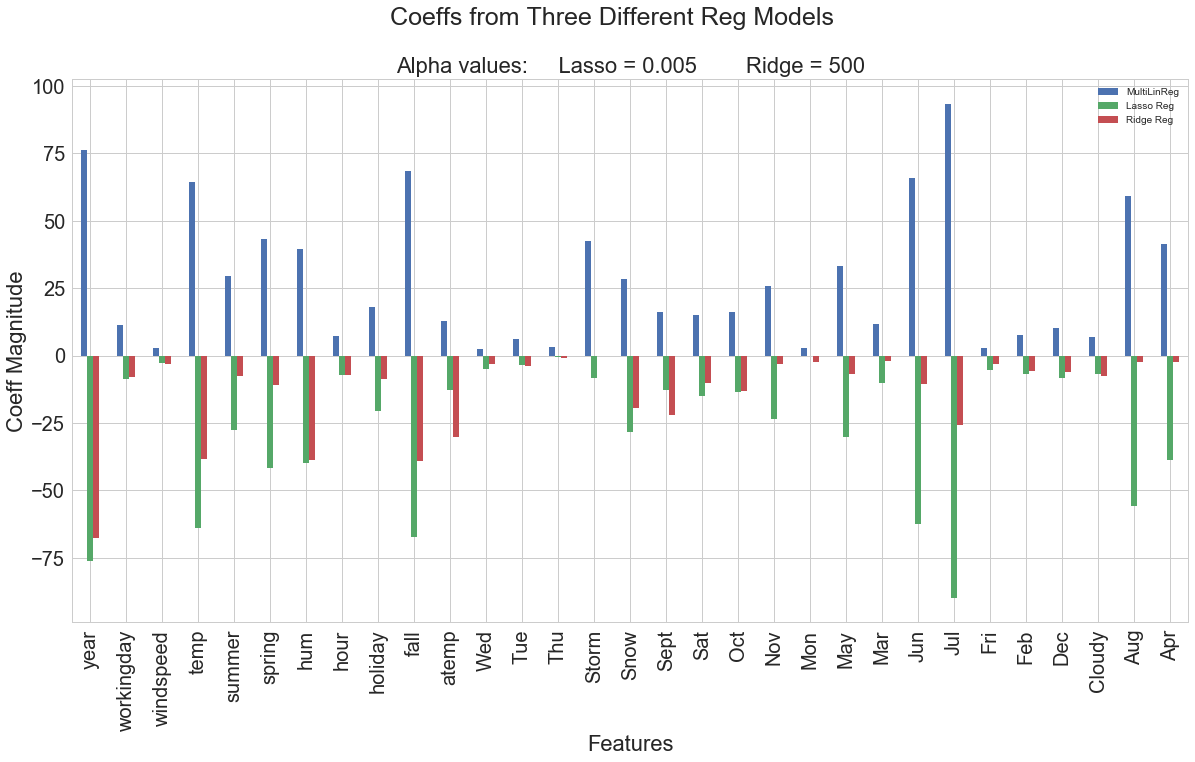

In [479]:
index = BikeOLSparams.keys()

rows = abs(BikeOLSModel.coef_)
rows2 = -abs(LassoCV_object.coef_)
rows3 = -abs(ridgeCV_object.coef_)
df = pd.DataFrame({'MultiLinReg': rows, 'Lasso Reg': rows2, 'Ridge Reg': rows3}, index=index)

# descending order
df = df.sort_values('MultiLinReg')

ax = df.sort_index(ascending=False).plot.bar(figsize=(20,10))
ax.set_xlabel("Features", fontsize=22)
ax.set_title('Alpha values:     Lasso = 0.005        Ridge = 500', fontsize=22)
ax.set_ylabel("Coeff Magnitude", fontsize=22)
ax.tick_params(labelsize=20)
plt.suptitle('Coeffs from Three Different Reg Models', fontsize=25);
print('(ALL VALUES ARE POSITIVE, PLOT SHOWS NEGATIVE TO MAKE IT EASIER TO DISPLAY)')

#### 2.6 Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients ...v

In [460]:
print('Ridge temp, atemp:', BikeRRparams['temp'], BikeRRparams['atemp'] )
print('Lasso temp, atemp:', BikeLRparams['temp'], BikeLRparams['atemp'] )

Ridge temp, atemp: 38.45620843577421 30.384088629049405
Lasso temp, atemp: 63.830861928234604 12.86839725489356


Looking at the printed aboves abobe, there is a stark differnce in the way Ridge and Lasso regression assign coefficients to predictors. For example, Ridge does not actually zero out coefficients and Lasso uses both variable selection and paramter shrinkage. This is why the temp value is very large and the atemp value from Lasso is very small. Due to the way the alogrhitm works, one values gets inflated and one shrinks down due to the paramter shrinkage. Ridge uses the parameter alpha/L2, which defines regularization strength. For Lasso, it uses lambda/L1. Lasso can set coefficients to zero, while ridge, cannot. This is because of the change of the constraint boundaries in the two cases. Lasso uses a "cross-polytope" to predict coefficients, whereas Ridge uses "n-sphere" to do the same, therefore they might look similar, but due to the difference in the shapes of the constraint boundaries, different coeffs are predicted. Lasso also looks at the absoulete values and finds points at the angle. 

#resources: https://stats.stackexchange.com/questions/866/when-should-i-use-lasso-vs-ridge
#https://stats.stackexchange.com/questions/251708/when-to-use-ridge-regression-and-lasso-regression-what-can-be-achieved-while-us
#https://en.wikipedia.org/wiki/Lasso_(statistics)


#### 2.7.1 How do the estimated coefficients compare to or differ from ...

Lasso compared favorably to the coefficents estimated by the plain linear regression in Q1. Looking at the graph in 2.5, we can see that the coeff magnitude differences between the plain linreg model and Lasso was very little for most of the features. There was only one feature, Storm, where linreg produced a drastically different value from Lasso. Ridge did not compare to the regular linreg. Outside of a few features, most of the magnitudes of the coeffs were drastically different. For example, for Jul, linreg produced a value of ~87 or so, whereas Ridge produced a value of ~30. SAme goes for April. Linreg gave us ~40, whereas Ridge gave us a value close to ~5. 

#### 2.7.2 Is there a difference between coefficients estimated by the two shrinkage methods ...

For some of the parameters, yes, there is a significant difference between the Lasso and Ridge shrinkage methods. For example, July, Ridge predicts around 30, whereas Lasso predicts around 85. The shape of their constraint boundaires is different. More speicifcally, Lasso uses a "cross-polytope" to predict coefficients, whereas Ridge uses "n-sphere". This is due to what I said above in 2.6. Due to this, there can be a difference between the estimations between the two shrinkage methods. Just looking at the differneces between temp/atemp (in 2.6) shows this. Ridge provides values are more more consistent with each other, whereas due to the shrinkage, Lasso can "balloon" some values and "deflate" others.

#### 2.7.3 Is the significance related to the shrinkage in some way?

Yes, as I said above in 2.6 and in 2.7.2, the significance is related to the shrinkage, more specifically, the two different shapes of the boundary constraints of L1/alpha and L2/lambda.

<div class='exercise'> <b> Question 3: Polynomial Features, Interaction Terms, and Cross Validation </b> </div>


We would like to fit a model to include all main effects and polynomial terms for numerical predictors up to the $4^{th}$ order. More precisely use the following terms: 
 - predictors in `X_train` and `X_test`
 - $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ for each numerical predictor $X_j$

**3.1** Create an expanded training set including all the desired terms mentioned above. Store that training set (as a pandas dataframe) in the variable `X_train_poly`.  Create the corresponding test set and store it as a pandas dataframe in `X_test_poly`.

**3.2** Discuss the following:

1. What are the dimensions of this 'design matrix' of all the predictor variables in 3.1?  
2. What issues may we run into attempting to fit a regression model using all of these predictors?

**3.3** Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train_poly`.  Store the fitted model in the variable `BikeOLSPolyModel`.

**3.4** Discuss the following:
1. What are the training and test $R^2$ scores? 
2. How does the model performance compare with the OLS model on the original set of features in Question 1?

**3.5** The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample sets of $R^2$ for our model. Use 5-fold cross-validation to generate $R^2$ scores for the multiple linear regression model with polynomial terms.  What are the mean and standard deviation of the $R^2$ scores for your model.

**3.6** Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

**3.7** We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives:

1. Multiple linear regression model generated based upon the feature set in Question 1 (let's call these the base features.
2. base features plus polynomial features to order 2
3. base features plus polynomial features to order 4

Use 5-fold cross validation on the training set to select the best model.  Make sure to evaluate all the models as much as possible on the same folds.  For each model generate a mean and standard deviation for the $R^2$ score.

**3.8** Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best?

**3.9** Evaluate each of the model alternatives on the test set.  How do the results compare with the results from cross-validation?

### Answers

#### 3.1 Create an expanded training set including all the desired terms mentioned above. Store that training set (as a numpy array) in the variable `X_train_poly`....

In [480]:
# Code from HW3

def gen_higher_order_features(df, feature_column, k):
    
    poly_model = PolynomialFeatures(k, include_bias=False)
    
    feature_data = df[feature_column]
    
    # transform to get all the polynomial features of this column
    higher_orders = poly_model.fit_transform(feature_data.values.reshape(-1,1))
    
    feature_names = poly_model.get_feature_names([feature_column])

    return pd.DataFrame(higher_orders[:,1:], columns = feature_names[1:])

continuous_columns = ['temp', 'atemp', 'hum', 'windspeed']

higher_orders_train =[gen_higher_order_features(X_train, feature, 4) for feature in continuous_columns]
higher_orders_test = [gen_higher_order_features(X_test, feature, 4) for feature in continuous_columns]

higher_orders_train = pd.concat(higher_orders_train, axis=1)
higher_orders_test = pd.concat(higher_orders_test, axis=1)

higher_orders_columns = higher_orders_train.columns

# standardize higher order polynomial features
scaler = StandardScaler().fit(higher_orders_train)

higher_orders_train[higher_orders_columns] = scaler.transform(higher_orders_train)
higher_orders_test[higher_orders_columns] = scaler.transform(higher_orders_test)

# had to reset index or it kept inputting NaN values!
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

X_train_poly = pd.concat([X_train, higher_orders_train], axis=1)
X_test_poly = pd.concat([X_test, higher_orders_test], axis=1)

X_test_poly.head()

# https://stackoverflow.com/questions/40339886/pandas-concat-generates-nan-values

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,summer,...,temp^4,atemp^2,atemp^3,atemp^4,hum^2,hum^3,hum^4,windspeed^2,windspeed^3,windspeed^4
0,6,0,0,0,-1.436131,-1.179015,0.885320,-1.557515,0,0,...,0.550735,0.363342,-0.607571,-0.048217,-0.198713,0.301867,-0.280943,0.884560,-0.810236,0.113435
1,9,0,0,0,-0.917170,-0.738176,0.678165,-1.557515,0,0,...,-0.337517,-0.423905,-0.124741,-0.406221,-0.496386,0.159758,-0.353046,0.884560,-0.810236,0.113435
2,20,0,0,0,-0.502000,-0.385738,1.247840,0.521907,0,0,...,-0.498855,-0.792867,0.009892,-0.466374,0.512022,0.766539,0.043090,-0.451391,-0.080324,-0.174841
3,10,0,0,0,-0.709585,-0.738176,0.937108,0.277655,0,0,...,-0.451260,-0.423905,-0.124741,-0.406221,-0.111969,0.349869,-0.252866,-0.572546,-0.102806,-0.178227
4,12,0,0,0,-0.709585,-0.826577,0.160279,0.889105,0,0,...,-0.451260,-0.295061,-0.188187,-0.369033,-0.895467,0.045265,-0.390789,-0.129963,0.024064,-0.147519


#### 3.2.1 What are the dimensions of this 'design matrix'...**

In [481]:
X_train_poly.shape

(13903, 43)

Shape of the design matrix is 13903 rows by 43 columns.

#### 3.2.2 What issues may we run into attempting to fit a regression model using all of these predictors? ...**

Fitting all of these predictors leads to "curse of dimensionality". This means that the training time grows exponentially. For example, if we tried to make a regression model with all features (with poly terms up to an order of 4), a "normal" computer would probably not be able to compute the sklearn linear regression algoritm. The design matrix would be far too large to be able to compute the fit efficiently. 

#### 3.3 Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model ....

In [482]:
linreg = LinearRegression()

BikeOLSPolyModel = linreg.fit(X_train_poly, y_train)

#### 3.4.1 What are the training and test $R^2$ scores?

In [483]:
BikeOLSPolyModel.predict(X_train_poly)

polyr2train = r2_score(y_train, BikeOLSPolyModel.predict(X_train_poly))
polyr2test = r2_score(y_test, BikeOLSPolyModel.predict(X_test_poly))

print('R2 for training set:', polyr2train)
print('R2 for testing set:', polyr2test)

R2 for training set: 0.42230805166587093
R2 for testing set: 0.42027912762252395


#### 3.4.2 How does the model performance compare with the OLS model on the original set of features in Question 1?

In [484]:
print('           OLS from Question 1 | Poly Regresstion Model')
print('R2 (train):', r2train, '|' , polyr2train)
print('R2 (test):', r2test, '|' , polyr2test)

           OLS from Question 1 | Poly Regresstion Model
R2 (train): 0.4065387827969087 | 0.42230805166587093
R2 (test): 0.40638554757102263 | 0.42027912762252395


The polynomical regression model shows a slightl improvement for both training and testing set versus the OLSModel from Question1. For example, the R2 value for the training set went from 0.406 to 0.4223. This represents a pretty good improvement in model performance.

#### 3.5 The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample...

In [487]:
splitter = KFold(5, random_state=42, shuffle=True)
lr_object =  BikeOLSPolyModel
scores = cross_val_score(lr_object, X_train_poly, y_train, cv=splitter)

print('R2 scores:', scores)
print('Std dev of R2 scores:', np.std(scores))
print('Mean R2 score:', np.mean(scores))

R2 scores: [0.44969585 0.39806258 0.4052678  0.42502773 0.41479757]
Std dev of R2 scores: 0.018012522649881575
Mean R2 score: 0.4185703055737381


#### 3.6 Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

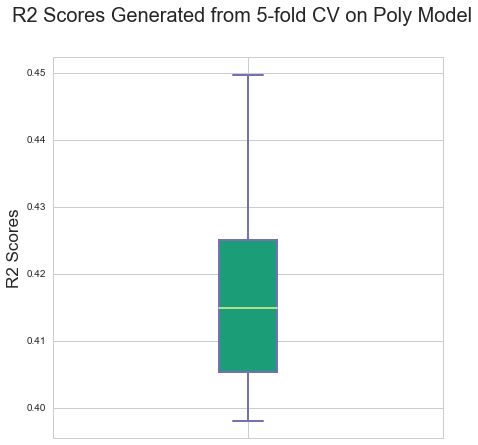

In [486]:
# Create a figure instance
fig = plt.figure(1, figsize=(7, 7))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(scores, patch_artist=True)

ax.set_xticklabels([''])
ax.set_ylabel('R2 Scores', fontsize=17);

for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)
    
    ## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

fig.suptitle('R2 Scores Generated from 5-fold CV on Poly Model', fontsize=20);

# USED CODE FROM HERE TO GRAPH PLOT: http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

#### 3.7 We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives ...

In [488]:
splitter = KFold(5, random_state=42, shuffle=True)

# 3.7.1

lr_object =  BikeOLSModel
scores1 = cross_val_score(lr_object, X_train, y_train, cv=splitter)

print('------')
print('3.7.1: Multiple linreg generated upon feature set in Q1')
print('------')
print('R2 scores:', scores1)
print('Std dev of R2 scores:', np.std(scores1))
print('Mean R2 score:', np.mean(scores1))
print('------')

# 3.7.2

continuous_columns = ['temp', 'atemp', 'hum', 'windspeed']

higher_orders_train =[gen_higher_order_features(X_train, feature, 2) for feature in continuous_columns]
higher_orders_test = [gen_higher_order_features(X_test, feature, 2) for feature in continuous_columns]

higher_orders_train = pd.concat(higher_orders_train, axis=1)
higher_orders_test = pd.concat(higher_orders_test, axis=1)

higher_orders_columns = higher_orders_train.columns

scaler = StandardScaler().fit(higher_orders_train)

higher_orders_train[higher_orders_columns] = scaler.transform(higher_orders_train)
higher_orders_test[higher_orders_columns] = scaler.transform(higher_orders_test)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

X_train_poly1 = pd.concat([X_train, higher_orders_train], axis=1)
X_test_poly1 = pd.concat([X_test, higher_orders_test], axis=1)

lr_object1 =  LinearRegression()
scores2 = cross_val_score(lr_object1, X_train_poly1, y_train, cv=splitter)

print('3.7.2: Base features plus poly to order 2')
print('------')
print('R2 scores:', scores2)
print('Std dev of R2 scores:', np.std(scores2))
print('Mean R2 score:', np.mean(scores2))
print('------')

# 3.7.3

higher_orders_train =[gen_higher_order_features(X_train, feature, 4) for feature in continuous_columns]
higher_orders_test = [gen_higher_order_features(X_test, feature, 4) for feature in continuous_columns]

higher_orders_train = pd.concat(higher_orders_train, axis=1)
higher_orders_test = pd.concat(higher_orders_test, axis=1)

higher_orders_columns = higher_orders_train.columns

scaler = StandardScaler().fit(higher_orders_train)

higher_orders_train[higher_orders_columns] = scaler.transform(higher_orders_train)
higher_orders_test[higher_orders_columns] = scaler.transform(higher_orders_test)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

X_train_poly2 = pd.concat([X_train, higher_orders_train], axis=1)
X_test_poly2 = pd.concat([X_test, higher_orders_test], axis=1)

scores3 = cross_val_score(lr_object1, X_train_poly2, y_train, cv=splitter)

print('3.7.3: Base features plus poly to order 4')
print('------')
print('R2 scores:', scores3)
print('Std dev of R2 scores:', np.std(scores3))
print('Mean R2 score:', np.mean(scores3))
print('------')


------
3.7.1: Multiple linreg generated upon feature set in Q1
------
R2 scores: [0.43367239 0.38407911 0.39334667 0.4075238  0.39970051]
Std dev of R2 scores: 0.016858979941951922
Mean R2 score: 0.40366449677749683
------
3.7.2: Base features plus poly to order 2
------
R2 scores: [0.44124112 0.3854012  0.39568835 0.4134964  0.40661133]
Std dev of R2 scores: 0.01896419980244762
Mean R2 score: 0.40848768150935716
------
3.7.3: Base features plus poly to order 4
------
R2 scores: [0.44969585 0.39806258 0.4052678  0.42502773 0.41479757]
Std dev of R2 scores: 0.018012522649881575
Mean R2 score: 0.4185703055737381
------


#### 3.8 Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best? ...

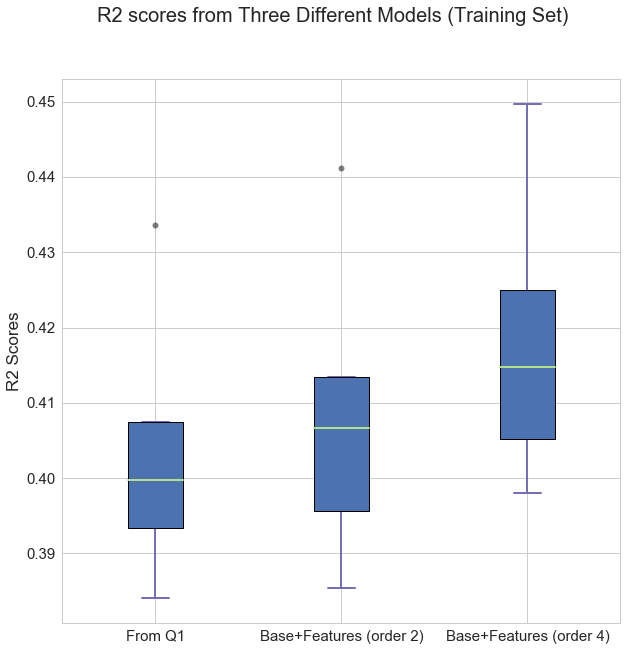

In [493]:
data_to_plot = [scores1, scores2, scores3]

fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot,patch_artist=True)
ax.set_ylabel('R2 Scores', fontsize=17);
ax.set_xticklabels(['From Q1', 'Base+Features (order 2)', 'Base+Features (order 4)'])
## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)
    
    ## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
ax.tick_params(labelsize=15)
fig.suptitle('R2 scores from Three Different Models (Training Set)', fontsize=20);

# USED CODE FROM HERE TO GRAPH PLOT: http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

In my opinion, yes, the box/whisker plot does influence my view on which model was best. For example, the highest R2 score was produced by the third model (base features + poly to order 4). The height of the box shows the distribution of R2 values (standard dev) and the green line inside the box shows the mean R2 score for that model. In this case, the model with the smallest std dev was model 1 from Q1, but it did produce a lower R2 score than the best model, which was the third one.

#### 3.9 Evaluate each of the model alternatives on the  test set.  How do the results compare with the results from cross-validation?

In [501]:
# 3.9.1

print('------')
print('TEST SET')
print('3.9.1: Multiple linreg generated upon feature set in Q1:')
print('R2 scores:', BikeOLSModel.score(X_test, y_test))
print('------')

# 3.9.2

linreg = LinearRegression()
BikeOLSPoly2Model = linreg.fit(X_train_poly1, y_train)
print('3.9.2: Base + Features (Order 2):')
print('R2 scores:', BikeOLSPoly2Model.score(X_test_poly1, y_test))
print('------')

# 3.9.3

print('3.9.3: Base + Features (Order 4):')
print('R2 scores:', BikeOLSPolyModel.score(X_test_poly, y_test))
print('------')

------
TEST SET
3.9.1: Multiple linreg generated upon feature set in Q1:
R2 scores: 0.40638554757102263
------
3.9.2: Base + Features (Order 2):
R2 scores: 0.4107603742280451
------
3.9.3: Base + Features (Order 4):
R2 scores: 0.42027912762252395
------


Model 1, Multiple Line Reg

The test R2 score from the model was higher than the mean R2 score from cross validation, however it was within one standard deviation, therefore very good.

Model 2, base features plus poly terms to order 2

Test R2 score, again, was higher than the mean R2 score from 5-fold CV, however it was within 1 standard deviations of the mean, so it compared very well again.

Model 3, base features plus poly terms to order 4

This model produced the best results for both the test and training R2 values. The test R2 value was very very close to the mean R2 score from the 5-fold CV. Under one standard deviation apart.

Therefore, Model 3 produced the best values with base features plus poly terms to order 4!